In [1]:
#Note accounting CRSP info seems to be in millions

import pandas as pd
import numpy as np
import os


import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
import statsmodels.api as sm

# importing required modules
from zipfile import ZipFile
import zipfile
import time

In [2]:
#Compustat data - roughly 1min to load 
fundamentals = pd.concat((chunk for chunk in pd.read_csv('fundamentals.csv',chunksize=100000, low_memory=False)))
fundamentals.shape #~500k rows, 659 columns 

(501147, 659)

In [3]:
fundamentals['cusip'] = fundamentals['cusip'].astype(str).str[:-1]

In [4]:
fundamentals['cusip']

0         00036110
1         00036110
2         00036110
3         00036110
4         00036110
            ...   
501142    21077C10
501143    21077C10
501144    21077C10
501145    21077C10
501146    21077C10
Name: cusip, Length: 501147, dtype: object

In [5]:
#CRSP data - roughly 10 seconds to load 
returns = pd.concat((chunk for chunk in pd.read_csv('returns.csv',chunksize=100000, low_memory=False)))
returns.shape #~5.7 million rows, 16 columns

(5711711, 16)

In [6]:
#cleaning up returns dataset - roughly 10 sec to load

returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format 
returns.sort_values(by='date') # This now sorts in date order
returns #returns in number format, not percentages 
returns[['prc','vol','ret','shrout','sprtrn']] = returns[['prc','vol','ret','shrout','sprtrn']].apply(pd.to_numeric, errors='coerce') #had to change the num to to numeric values 
#returns['ticker'].nunique() #have stock return data on 9,670 firms 
returns.head()

,Unnamed: 0,permno,date,siccd,ncusip,ticker,comnam,shrcls,naics,prc,vol,ret,shrout,cfacpr,cfacshr,sprtrn
0,0,10026,2018-01-02,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.17999,190618.0,-0.017454,18668.0,1.0,1.0,0.008303
1,1,10026,2018-01-03,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,147.69000,63693.0,-0.009988,18668.0,1.0,1.0,0.006399
2,2,10026,2018-01-04,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.73000,127552.0,0.013813,18668.0,1.0,1.0,0.004029
3,3,10026,2018-01-05,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.30000,44647.0,-0.009550,18668.0,1.0,1.0,0.007034
4,4,10026,2018-01-08,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.41000,55014.0,0.000742,18668.0,1.0,1.0,0.001662


In [7]:
fundamentals.sort_values(by='fyearq').reset_index() # This now sorts in date order
fundamentals.head()

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,ipodate
0,0,1004,2010-02-28,2009.0,3.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
1,1,1004,2010-05-31,2009.0,4.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
2,2,1004,2010-08-31,2010.0,1.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
3,3,1004,2010-11-30,2010.0,2.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
4,4,1004,2011-02-28,2010.0,3.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01


In [8]:
#group returns by quarter
#group return dates by 3/31, 6/30, 9/30, 12/31 


returns['Gross_Ret'] = 1 + returns['ret']

q2_2018 = ((returns[(returns['date'] >= '2018-03-31') & (returns['date'] <= '2018-06-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q3_2018 = ((returns[(returns['date'] >= '2018-06-30') & (returns['date'] <= '2018-09-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q4_2018 = ((returns[(returns['date'] >= '2018-09-30') & (returns['date'] <= '2018-12-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 

q1_2019 = ((returns[(returns['date'] >= '2018-12-31') & (returns['date'] <= '2019-03-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q2_2019 = ((returns[(returns['date'] >= '2019-03-31') & (returns['date'] <= '2019-06-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q3_2019 = ((returns[(returns['date'] >= '2019-06-30') & (returns['date'] <= '2019-09-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q4_2019 = ((returns[(returns['date'] >= '2019-09-30') & (returns['date'] <= '2019-12-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 

q1_2020 = ((returns[(returns['date'] >= '2019-12-31') & (returns['date'] <= '2020-03-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q2_2020 = ((returns[(returns['date'] >= '2020-03-31') & (returns['date'] <= '2020-06-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q3_2020 = ((returns[(returns['date'] >= '2020-06-30') & (returns['date'] <= '2020-09-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q4_2020 = ((returns[(returns['date'] >= '2020-09-30') & (returns['date'] <= '2020-12-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 

In [9]:
q1_2019

,ncusip,ticker,Gross_Ret
0,00030710,AAC,0.304962
1,00036020,AAON,0.325110
2,00036110,AIR,-0.116952
3,00037520,ABB,-0.003171
4,00081T10,ACCO,0.280592
...,...,...,...
7688,Y8564W10,TK,0.184951
7689,Y8565J10,TOO,-0.024388
7690,Y8565N10,TNK,0.032023
7691,Y8897Y80,TOPS,-0.029583


In [10]:
# Merge = pd.merge(fundamentals.loc[fundamentals['datadate']]=='2020-06-30', q3_2020a,left_on='cusip', right_on='ncusip', how='right',indicator=True,validate='many_to_one')
# Merge.tail(20)

q1_2018_acct = fundamentals[fundamentals['datadate'] == '2018-03-31']
q2_2018_acct = fundamentals[fundamentals['datadate'] == '2018-06-30']
q3_2018_acct = fundamentals[fundamentals['datadate'] == '2018-09-30']
q4_2018_acct = fundamentals[fundamentals['datadate'] == '2018-12-31']

q1_2019_acct = fundamentals[fundamentals['datadate'] == '2019-03-31']
q2_2019_acct = fundamentals[fundamentals['datadate'] == '2019-06-30']
q3_2019_acct = fundamentals[fundamentals['datadate'] == '2019-09-30']
q4_2019_acct = fundamentals[fundamentals['datadate'] == '2019-12-31']

q1_2020_acct = fundamentals[fundamentals['datadate'] == '2020-03-31']
q2_2020_acct = fundamentals[fundamentals['datadate'] == '2020-06-30']
q3_2020_acct = fundamentals[fundamentals['datadate'] == '2020-09-30']
q4_2020_acct = fundamentals[fundamentals['datadate'] == '2020-12-31']

q1_2018_acct


#df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]

# Merge = pd.merge(q2_2020_acct, q3_2020,left_on='cusip', right_on='ncusip',how='left',indicator=True)
# Merge

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,ipodate
80,80,1045,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,4.0,4512.0,605.0,600.0,C,TX,0.0,www.aa.com,NaN
124,124,1050,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,3564.0,345.0,925.0,C,TX,0.0,www.cecoenviro.com,NaN
211,211,1072,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,NaN,1.0,3670.0,220.0,925.0,B-,SC,0.0,www.avx.com,1973-03-01
251,251,1075,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,4911.0,705.0,700.0,A,AZ,0.0,www.pinnaclewest.com,NaN
295,295,1076,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,6141.0,175.0,976.0,B,UT,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501048,501048,329141,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,01W,90.0,7372.0,NaN,NaN,NaN,NaN,0.0,www.renalytixai.com,2020-07-17
501064,501064,330227,2018-03-31,2018.0,2.0,9.0,INDL,C,D,STD,...,01W,1.0,4412.0,NaN,NaN,NaN,NaN,0.0,www.castormaritime.com,2019-02-11
501102,501102,335466,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,www.hermitage-offshore.com,NaN
501123,501123,345920,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,3524.0,NaN,NaN,NaN,PA,0.0,www.hydrofarm.com,2020-12-10


In [11]:
Merge_q1_2018 = pd.merge(q1_2018_acct, q2_2018, left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q2_2018 = pd.merge(q2_2018_acct, q3_2018, left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q3_2018 = pd.merge(q3_2018_acct, q4_2018, left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q4_2018 = pd.merge(q4_2018_acct, q1_2019, left_on='cusip', right_on='ncusip',how='inner',indicator=True)

Merge_q1_2019 = pd.merge(q1_2019_acct, q2_2019,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q2_2019 = pd.merge(q2_2019_acct, q3_2019,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q3_2019 = pd.merge(q3_2019_acct, q4_2019,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q4_2019 = pd.merge(q4_2019_acct, q1_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)

Merge_q1_2020 = pd.merge(q1_2020_acct, q2_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q2_2020 = pd.merge(q2_2020_acct, q3_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q3_2020 = pd.merge(q3_2020_acct, q4_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)





In [12]:
frames = [Merge_q1_2018, Merge_q2_2018, Merge_q3_2018, Merge_q4_2018, 
          Merge_q1_2019, Merge_q2_2019, Merge_q3_2019, Merge_q4_2019, 
          Merge_q1_2020, Merge_q2_2020, Merge_q3_2020]

Final = pd.concat(frames)
#Final.sort_values(by='datadate',ascending=True).reset_index() # This now sorts in date order

Final.tail(20)
Final.iloc[350:370]

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,spcseccd,spcsrc,state,stko,weburl,ipodate,ncusip,ticker,Gross_Ret,_merge
350,27667,6900,2018-03-31,2018.0,2.0,9.0,INDL,C,D,STD,...,940.0,B-,MN,0.0,www.mts.com,NaN,55377710,MTSC,0.025086,both
351,27750,6932,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,700.0,A-,WI,0.0,www.mgeenergy.com,NaN,55277P10,MGEE,0.129965,both
352,27822,6946,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,A,ON,0.0,www.magna.com,NaN,55922240,MGA,0.036857,both
353,27917,6994,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,925.0,C,WI,0.0,www.manitowoc.com,NaN,56357140,MTW,-0.091356,both
354,27979,7017,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,935.0,C,TX,0.0,www.marathonoil.com,NaN,56584910,MRO,0.296284,both
355,28025,7022,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,B,WI,0.0,www.marcuscorp.com,NaN,56633010,MCS,0.075908,both
356,28069,7034,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,800.0,B-,TX,0.0,www.marps-marine.com,NaN,56842310,MARPS,0.282305,both
357,28113,7063,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,800.0,B,MD,0.0,www.hosthotels.com,NaN,44107P10,HST,0.141204,both
358,28157,7065,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,800.0,A,NY,0.0,www.mmc.com,NaN,57174810,MMC,-0.002891,both
359,28206,7085,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,B,MI,0.0,masco.com,NaN,57459910,MAS,-0.072298,both


In [13]:
Final.shape

(69668, 663)

In [14]:
Final['ticker'].nunique() #8012 unique tickers 
Final['ncusip'].nunique() #7944 unique ncusip
#ticker and ncusip should match up!!!!

Final['cusip'].nunique() #11,453 unique cusip identifers 
Final['ticker'].value_counts()
#Final['ncusip'].value_counts()


VVPR    14
RXN     14
CTHR    14
FOR     13
GCI     12
        ..
HDNG     1
APSG     1
CCCC     1
BGC      1
GCOR     1
Name: ticker, Length: 8012, dtype: int64

In [15]:
_Final = Final
_Final.drop_duplicates()
_Final
_Final[_Final['ticker'].str.contains("CTHR")]


,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,spcseccd,spcsrc,state,stko,weburl,ipodate,ncusip,ticker,Gross_Ret,_merge
3593,254743,65850,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.213236,both
3594,254744,65850,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.213236,both
3708,254745,65850,2018-06-30,2018.0,4.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.184206,both
3709,254746,65850,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.184206,both
3798,254747,65850,2018-09-30,2018.0,3.0,12.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.026237,both
3799,254748,65850,2018-09-30,2019.0,1.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.026237,both
3877,254749,65850,2018-12-31,2019.0,2.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,0.310346,both
3999,254750,65850,2019-03-31,2019.0,3.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,0.385964,both
4118,254751,65850,2019-06-30,2019.0,4.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,0.031643,both
4204,254752,65850,2019-09-30,2020.0,1.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.089741,both


In [16]:
_Final.columns[120:130]
_Final.columns[175]


'invrmq'

In [17]:
_Final.groupby(['ticker','datadate'])['niq'].mean()
_Final.groupby(['ticker','datadate'])['atq'].mean()
_Final['dvpsxq']
_Final['prccq']
_Final['revtq']

0       10401.000
1          74.139
2         446.632
3         692.714
4        7390.000
          ...    
6788          NaN
6789        0.000
6790        0.288
6791       96.658
6792      606.000
Name: revtq, Length: 69668, dtype: float64

### useful columns
niq: net income (in millions)
dvpsxq: dividends per share
revtq: revenue 


In [18]:
metrics = pd.read_stata('metrics.dta')
metrics.head(15)

#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 



,adate,qdate,public_date,evm,pe_exi,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER,cusip
0,2017-05-31,2017-11-30,2018-01-31,13.627491,25.293750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.524219,NaN,0.007413,AIR,00036110
1,2017-05-31,2017-11-30,2018-02-28,13.627491,26.612500,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.603688,NaN,0.007046,AIR,00036110
2,2017-05-31,2017-11-30,2018-03-31,13.627491,27.568750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.657007,NaN,0.006801,AIR,00036110
3,2017-05-31,2018-02-28,2018-04-30,12.982963,20.817308,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.614672,NaN,0.006928,AIR,00036110
4,2017-05-31,2018-02-28,2018-05-31,12.982963,21.485577,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.666505,NaN,0.006713,AIR,00036110
5,2017-05-31,2018-02-28,2018-06-30,12.982963,22.350962,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.733628,NaN,0.006453,AIR,00036110
6,2018-05-31,2018-05-31,2018-07-31,13.665281,22.469194,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.730067,NaN,0.006328,AIR,00036110
7,2018-05-31,2018-05-31,2018-08-31,13.665281,22.118483,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.703063,NaN,0.006428,AIR,00036110
8,2018-05-31,2018-05-31,2018-09-30,13.665281,22.696682,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.762724,NaN,0.006264,AIR,00036110
9,2018-05-31,2018-08-31,2018-10-31,13.105509,20.333333,0.044917,0.189685,0.086178,0.086684,0.045337,0.659570,1.773482,NaN,0.006305,AIR,00036110


In [19]:
#for each qdate and cusip, take the first qdate option 

metrics_adj = metrics.drop_duplicates(
  subset = ['qdate', 'cusip'],
  keep = 'first').reset_index(drop = True)
metrics_adj

,adate,qdate,public_date,evm,pe_exi,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER,cusip
0,2017-05-31,2017-11-30,2018-01-31,13.627491,25.293750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.524219,NaN,0.007413,AIR,00036110
1,2017-05-31,2018-02-28,2018-04-30,12.982963,20.817308,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.614672,NaN,0.006928,AIR,00036110
2,2018-05-31,2018-05-31,2018-07-31,13.665281,22.469194,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.730067,NaN,0.006328,AIR,00036110
3,2018-05-31,2018-08-31,2018-10-31,13.105509,20.333333,0.044917,0.189685,0.086178,0.086684,0.045337,0.659570,1.773482,NaN,0.006305,AIR,00036110
4,2018-05-31,2018-11-30,2019-01-31,12.598434,16.599119,0.042077,0.186303,0.090734,0.084956,0.045337,0.662693,1.397717,NaN,0.007962,AIR,00036110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45741,2019-12-31,2019-12-31,2020-02-29,-2.110395,-1.498039,NaN,NaN,NaN,NaN,NaN,0.744055,2.148020,NaN,NaN,ARMP,04216R10
45742,2019-12-31,2020-03-31,2020-05-31,-2.383779,-1.556485,NaN,NaN,-0.627996,-1.371752,NaN,0.505825,1.897191,NaN,NaN,ARMP,04216R10
45743,2019-12-31,2020-06-30,2020-08-31,-2.946872,-1.714286,-688.032258,NaN,-0.560890,-0.843502,NaN,0.547478,1.848924,NaN,NaN,ARMP,04216R10
45744,2019-12-31,2020-09-30,2020-11-30,-3.583620,-2.156463,-63.144201,NaN,-0.477488,-0.744982,NaN,0.609360,2.140574,NaN,NaN,ARMP,04216R10


In [20]:
metrics_adj['qdate']=metrics_adj['qdate'].astype(str) #convert to string so that we can merge with datadate 
metrics['qdate'].head()

0   2017-11-30
1   2017-11-30
2   2017-11-30
3   2018-02-28
4   2018-02-28
Name: qdate, dtype: datetime64[ns]

In [21]:
Final['datadate'].dtypes
metrics_adj['qdate'].dtypes

dtype('O')

In [22]:
data_with_metrics = pd.merge(Final, metrics_adj,  how='inner', left_on=['cusip','datadate'], right_on = ['cusip','qdate'])
#data_with_metrics.sort_values(['TICKER','datadate']).reset_index()# This now sorts in date order
data_with_metrics.head(20)

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER
0,80,1045,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.025484,0.328241,0.129348,0.292062,0.377756,18.904739,5.148619,1.722300,0.009187,AAL
1,124,1050,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.008256,0.335112,0.048277,0.013210,3.149752,1.296207,0.975482,0.213359,NaN,CECE
2,211,1072,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,0.003142,0.245048,0.094114,0.002195,0.974469,0.191368,1.141916,NaN,0.030085,AVX
3,251,1075,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.130818,0.398014,0.085254,0.059396,0.337072,2.359600,1.288686,3.634455,0.034920,PNW
4,339,1078,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.013218,0.628300,0.097544,0.011759,0.832447,1.301136,3.435576,NaN,0.018203,ABT
5,433,1094,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,-0.379090,0.235754,0.050640,-0.686320,0.344738,1.852784,0.609787,NaN,0.098485,ACET
6,556,1104,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.030904,0.390004,0.101426,0.084574,0.375943,1.205887,1.510188,NaN,0.019469,ACU
7,689,1121,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.001078,0.018175,0.062366,0.010233,NaN,0.804912,1.264578,1.689230,0.019923,AE
8,733,1161,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.014156,0.377490,0.105835,0.164634,0.306452,5.300928,18.614116,NaN,NaN,AMD
9,835,1177,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.057748,0.270891,0.107536,0.229092,0.363302,2.613357,3.513363,0.268924,0.011355,AET


In [23]:
a =data_with_metrics[data_with_metrics['TICKER'] == 'AAL']
sm_ols('Gross_Ret ~ npm + gpm ', data=data_with_metrics).fit().summary()
#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09079
Date:                Mon, 19 Apr 2021   Prob (F-statistic):              0.913
Time:                        16:26:08   Log-Likelihood:                -15707.
No. Observations:               30364   AIC:                         3.142e+04
Df Residuals:                   30361   BIC:                         3.145e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0623      0.002     26.723      0.000       0.058       0.067
npm        -1.417e-07   1.18e-05     -0.012      0.990   -2.33e-05     2.3e-05
gpm        -3.881e-06    1.4e-05     -0.277      0.782   -3.13e-05    2.36e-05
==============================================================================
Omnibus:                    37203.420   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17772390.619
Skew:                           6.166   Prob(JB):                         0.00
Kurtosis:                     120.879   Cond. No.                         359.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
Food_bev_group = data_with_metrics[data_with_metrics['naics'] == 445110]
Food_bev_group #WMK, IMKTA, SFM, SFS, IFMK, GO
#Food_bev_group['TICKER'].nunique() #6 firms within this category 

#Grocery_group = data_with_metrics[data_with_metrics['sic'] == 5411]
#Grocery_group['TICKER'].nunique() #6 firms within this category 
#Grocery_group #WMK, IMKTA, SFM, SFS, IFMK, GO


#as you can see, using naics or sic work in this case 

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER
542,48850,11343,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.029441,0.263099,0.116293,0.096285,-0.245384,0.461656,1.349388,0.576120,0.022006,WMK
625,57952,12972,2018-03-31,2018.0,2.0,9.0,INDL,C,D,STD,...,0.020957,0.267795,0.140078,0.148061,0.360637,2.299270,0.669191,0.353181,0.022997,IMKTA
806,91208,17934,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.037082,0.317831,0.217476,0.264991,0.229070,1.449301,4.169589,0.684821,NaN,SFM
937,110486,19843,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,-0.030611,0.161589,0.059469,-0.233177,NaN,2.913670,0.783625,NaN,NaN,SFS
1543,191535,30262,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,-0.005787,0.228380,0.010534,-0.009273,NaN,7.955535,16.002983,NaN,NaN,IFMK
3370,48851,11343,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,0.029665,0.265387,0.117822,0.096201,-0.245384,0.440363,1.139019,0.550350,0.025757,WMK
3453,57953,12972,2018-06-30,2018.0,3.0,9.0,INDL,C,D,STD,...,0.023844,0.266303,0.138770,0.167072,0.360637,2.218969,0.787480,0.264068,0.018359,IMKTA
3634,91209,17934,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,0.036201,0.323841,0.214048,0.264705,0.229070,1.560121,5.209129,0.788162,NaN,SFM
3766,110487,19843,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,-0.030414,0.161662,0.060870,-0.257086,NaN,3.160561,1.181193,NaN,NaN,SFS
4370,191536,30262,2018-06-30,2018.0,1.0,3.0,INDL,C,D,STD,...,-0.017398,0.227789,0.002697,-0.405061,NaN,8.521136,13.610438,NaN,NaN,IFMK


In [27]:
data_with_metrics['sic']
data_with_metrics['naics'] #north american industry classification code 
data_with_metrics['naics'].isnull().value_counts()
# data_with_metrics['sic'].isnull().value_counts() #sic has 3 null values


False    32759
Name: naics, dtype: int64

In [28]:
sm_ols('Gross_Ret ~ npm + gpm + roa + roe',data=Food_bev_group).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.112
Date:                Mon, 19 Apr 2021   Prob (F-statistic):             0.0942
Time:                        16:27:54   Log-Likelihood:                -27.167
No. Observations:                  52   AIC:                             64.33
Df Residuals:                      47   BIC:                             74.09
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5929      0.494     -1.200      0.236      -1.587       0.401
npm           -9.9414      6.522     -1.524      0.134     -23.062       3.180
gpm            1.5548      1.798      0.865      0.392      -2.063       5.173
roa            2.7725      1.830      1.515      0.136      -0.909       6.454
roe           -0.0537      0.104     -0.518      0.607      -0.262       0.155
==============================================================================
Omnibus:                       40.040   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.624
Skew:                           1.557   Prob(JB):                     2.65e-72
Kurtosis:                      14.935   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
sm_ols('Gross_Ret ~ roe',data=data_with_metrics).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0001342
Date:                Mon, 19 Apr 2021   Prob (F-statistic):              0.991
Time:                        16:27:57   Log-Likelihood:                -15456.
No. Observations:               30559   AIC:                         3.092e+04
Df Residuals:                   30557   BIC:                         3.093e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0615      0.002     26.783      0.000       0.057       0.066
roe         2.592e-07   2.24e-05      0.012      0.991   -4.36e-05    4.41e-05
==============================================================================
Omnibus:                    36393.627   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16115182.025
Skew:                           5.859   Prob(JB):                         0.00
Kurtosis:                     114.888   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
dat_filter = data_with_metrics

dat_filter['Gross_Ret'] = dat_filter['Gross_Ret'][dat_filter['Gross_Ret'].between(dat_filter['Gross_Ret'].quantile(.15), dat_filter['Gross_Ret'].quantile(.85))] # without outliers
dat_filter['roa'] = dat_filter['roa'][dat_filter['roa'].between(dat_filter['roa'].quantile(.15), dat_filter['roa'].quantile(.85))] # without outliers
dat_filter['roe'] = dat_filter['roe'][dat_filter['roe'].between(dat_filter['roe'].quantile(.15), dat_filter['roe'].quantile(.85))] # without outliers
dat_filter['evm'] = dat_filter['evm'][dat_filter['evm'].between(dat_filter['evm'].quantile(.15), dat_filter['evm'].quantile(.85))] # without outliers
dat_filter['pe_exi'] = dat_filter['pe_exi'][dat_filter['pe_exi'].between(dat_filter['pe_exi'].quantile(.15), dat_filter['pe_exi'].quantile(.85))] # without outliers
dat_filter['ptb'] = dat_filter['ptb'][dat_filter['ptb'].between(dat_filter['ptb'].quantile(.15), dat_filter['ptb'].quantile(.85))] # without outliers
dat_filter['npm'] = dat_filter['npm'][dat_filter['npm'].between(dat_filter['npm'].quantile(.15), dat_filter['npm'].quantile(.85))] # without outliers
dat_filter['gpm'] = dat_filter['gpm'][dat_filter['gpm'].between(dat_filter['gpm'].quantile(.15), dat_filter['gpm'].quantile(.85))] # without outliers
dat_filter['de_ratio'] = dat_filter['de_ratio'][dat_filter['de_ratio'].between(dat_filter['de_ratio'].quantile(.15), dat_filter['de_ratio'].quantile(.85))] # without outliers
dat_filter['PEG_trailing'] = dat_filter['PEG_trailing'][dat_filter['PEG_trailing'].between(dat_filter['PEG_trailing'].quantile(.15), dat_filter['PEG_trailing'].quantile(.85))] # without outliers
dat_filter['divyield'] = dat_filter['divyield'][dat_filter['divyield'].between(dat_filter['divyield'].quantile(.15), dat_filter['divyield'].quantile(.85))] # without outliers

#dat_filter_2018 = dat_filter[dat_filter['fyearq'] == 2018.0] #filter by 2018 year 


#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income
#ptb: price/book
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 


#sns.regplot(x='roa',y='Gross_Ret',data=dat_filter)

In [31]:
dat_filter

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER
0,80,1045,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.025484,0.328241,0.129348,NaN,0.377756,NaN,5.148619,1.722300,NaN,AAL
1,124,1050,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.008256,0.335112,0.048277,0.013210,3.149752,1.296207,0.975482,0.213359,NaN,CECE
2,211,1072,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,0.003142,0.245048,0.094114,0.002195,0.974469,NaN,1.141916,NaN,0.030085,AVX
3,251,1075,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.130818,0.398014,0.085254,0.059396,0.337072,2.359600,1.288686,NaN,0.034920,PNW
4,339,1078,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.013218,0.628300,0.097544,0.011759,0.832447,1.301136,3.435576,NaN,0.018203,ABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32754,500391,315318,2020-09-30,2020.0,3.0,12.0,INDL,C,D,STD,...,0.068405,0.516198,0.086169,0.053145,0.435060,0.989652,1.470479,NaN,0.014482,ESI
32755,500911,325576,2020-09-30,2020.0,3.0,12.0,INDL,C,D,STD,...,NaN,NaN,NaN,NaN,NaN,NaN,1.619574,NaN,NaN,APG
32756,501044,328795,2020-09-30,2020.0,3.0,12.0,INDL,C,D,STD,...,0.060927,0.251612,0.112798,0.062098,0.228202,0.379196,1.259593,NaN,NaN,ACA
32757,501092,331856,2020-09-30,2020.0,3.0,12.0,INDL,C,D,STD,...,NaN,NaN,NaN,NaN,NaN,NaN,2.382490,NaN,NaN,IMUX


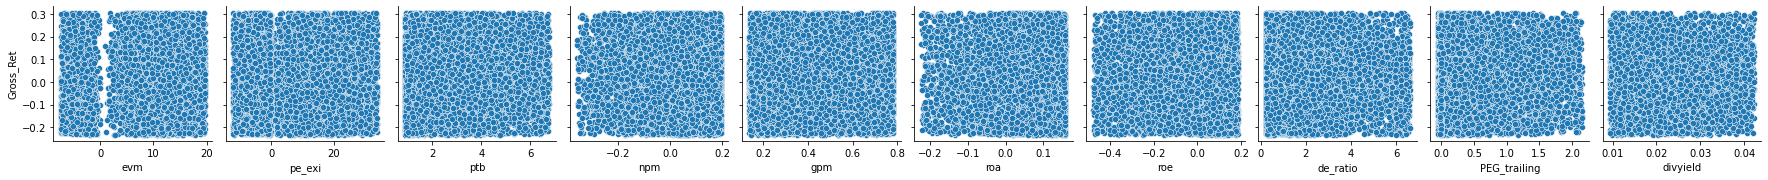

In [32]:
sns.pairplot(data=dat_filter,
             y_vars=['Gross_Ret'],
            x_vars=['evm','pe_exi','ptb','npm','gpm','roa','roe','de_ratio','PEG_trailing','divyield'])

#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 

In [ ]:
dat_filter.describe()

In [34]:
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter).fit().summary()

#sm_ols('Gross_Ret ~ pe_exi ',data=dat_filter).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.509
Date:                Mon, 19 Apr 2021   Prob (F-statistic):           3.21e-06
Time:                        16:29:01   Log-Likelihood:                 611.92
No. Observations:                 793   AIC:                            -1202.
Df Residuals:                     782   BIC:                            -1150.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2039      0.042      4.823      0.000       0.121       0.287
evm             -0.0118      0.002     -5.737      0.000      -0.016      -0.008
pe_exi           0.0009      0.001      1.068      0.286      -0.001       0.003
npm             -0.0080      0.107     -0.074      0.941      -0.219       0.203
gpm             -0.0312      0.038     -0.815      0.415      -0.106       0.044
roa             -0.8509      0.232     -3.664      0.000      -1.307      -0.395
roe              0.0581      0.112      0.521      0.603      -0.161       0.277
de_ratio        -0.0090      0.005     -1.941      0.053      -0.018       0.000
ptb              0.0302      0.009      3.535      0.000       0.013       0.047
PEG_trailing     0.0126      0.008      1.584      0.114      -0.003       0.028
divyield        -0.3351      0.513     -0.653      0.514      -1.343       0.672
==============================================================================
Omnibus:                        3.949   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.313
Skew:                          -0.063   Prob(JB):                        0.191
Kurtosis:                       2.710   Cond. No.                     2.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
dat_filter_2018 = dat_filter[dat_filter['fyearq'] == 2018.0]
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_2018).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.896
Date:                Mon, 19 Apr 2021   Prob (F-statistic):            0.00185
Time:                        16:35:21   Log-Likelihood:                 215.83
No. Observations:                 287   AIC:                            -409.7
Df Residuals:                     276   BIC:                            -369.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2068      0.085      2.434      0.016       0.040       0.374
evm             -0.0143      0.004     -3.878      0.000      -0.022      -0.007
pe_exi           0.0023      0.002      1.451      0.148      -0.001       0.005
npm              0.0109      0.191      0.057      0.955      -0.365       0.387
gpm              0.0311      0.069      0.453      0.651      -0.104       0.166
roa             -1.7002      0.456     -3.728      0.000      -2.598      -0.802
roe              0.2041      0.227      0.898      0.370      -0.243       0.652
de_ratio        -0.0232      0.009     -2.456      0.015      -0.042      -0.005
ptb              0.0442      0.018      2.507      0.013       0.009       0.079
PEG_trailing     0.0147      0.014      1.056      0.292      -0.013       0.042
divyield         0.9321      0.869      1.073      0.284      -0.778       2.643
==============================================================================
Omnibus:                        2.121   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                1.975
Skew:                           0.119   Prob(JB):                        0.372
Kurtosis:                       2.671   Cond. No.                     2.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
dat_filter_2019 = dat_filter[dat_filter['fyearq'] == 2019.0]
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_2019).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.447
Date:                Mon, 19 Apr 2021   Prob (F-statistic):           7.08e-06
Time:                        16:36:03   Log-Likelihood:                 290.28
No. Observations:                 329   AIC:                            -558.6
Df Residuals:                     318   BIC:                            -516.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2819      0.057      4.968      0.000       0.170       0.394
evm             -0.0139      0.003     -4.732      0.000      -0.020      -0.008
pe_exi          -0.0005      0.001     -0.440      0.660      -0.003       0.002
npm              0.0557      0.152      0.366      0.714      -0.244       0.355
gpm             -0.0932      0.052     -1.776      0.077      -0.196       0.010
roa             -0.6778      0.305     -2.224      0.027      -1.277      -0.078
roe             -0.1441      0.175     -0.823      0.411      -0.489       0.200
de_ratio        -0.0073      0.006     -1.229      0.220      -0.019       0.004
ptb              0.0425      0.012      3.465      0.001       0.018       0.067
PEG_trailing     0.0054      0.011      0.488      0.626      -0.016       0.027
divyield        -2.0075      0.757     -2.652      0.008      -3.497      -0.518
==============================================================================
Omnibus:                        1.377   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.353
Skew:                          -0.068   Prob(JB):                        0.508
Kurtosis:                       2.717   Cond. No.                     3.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
dat_filter_2020 = dat_filter[dat_filter['fyearq'] == 2020.0]
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_2020).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9823
Date:                Mon, 19 Apr 2021   Prob (F-statistic):              0.461
Time:                        16:36:44   Log-Likelihood:                 148.99
No. Observations:                 176   AIC:                            -276.0
Df Residuals:                     165   BIC:                            -241.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1709      0.091      1.886      0.061      -0.008       0.350
evm             -0.0081      0.004     -1.840      0.068      -0.017       0.001
pe_exi           0.0003      0.002      0.178      0.859      -0.003       0.004
npm             -0.0166      0.216     -0.077      0.939      -0.443       0.410
gpm              0.0008      0.083      0.010      0.992      -0.163       0.164
roa             -0.2133      0.498     -0.429      0.669      -1.196       0.770
roe              0.2090      0.184      1.136      0.258      -0.154       0.572
de_ratio        -0.0001      0.010     -0.014      0.989      -0.019       0.019
ptb              0.0078      0.015      0.522      0.603      -0.022       0.038
PEG_trailing     0.0175      0.017      1.013      0.312      -0.017       0.052
divyield        -1.1697      1.046     -1.118      0.265      -3.236       0.897
==============================================================================
Omnibus:                        1.095   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                1.182
Skew:                          -0.135   Prob(JB):                        0.554
Kurtosis:                       2.703   Cond. No.                     2.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
dat_filter_q1 = dat_filter[dat_filter.datadate.str.endswith('03-31')] #filter by rows ending in 3-31
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.448
Date:                Mon, 19 Apr 2021   Prob (F-statistic):            0.00873
Time:                        16:44:10   Log-Likelihood:                 215.80
No. Observations:                 223   AIC:                            -409.6
Df Residuals:                     212   BIC:                            -372.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2162      0.076      2.848      0.005       0.067       0.366
evm             -0.0119      0.004     -3.301      0.001      -0.019      -0.005
pe_exi           0.0014      0.001      1.037      0.301      -0.001       0.004
npm              0.3151      0.181      1.743      0.083      -0.041       0.672
gpm             -0.0080      0.063     -0.127      0.899      -0.132       0.116
roa             -1.1446      0.384     -2.980      0.003      -1.902      -0.387
roe              0.2030      0.196      1.036      0.301      -0.183       0.589
de_ratio        -0.0211      0.008     -2.726      0.007      -0.036      -0.006
ptb              0.0266      0.015      1.804      0.073      -0.002       0.056
PEG_trailing     0.0060      0.012      0.495      0.621      -0.018       0.030
divyield        -0.1213      0.783     -0.155      0.877      -1.665       1.422
==============================================================================
Omnibus:                        0.230   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.132
Skew:                          -0.058   Prob(JB):                        0.936
Kurtosis:                       3.026   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
dat_filter_q2 = dat_filter[dat_filter.datadate.str.endswith('06-30')] #filter by rows ending in 6-30
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.688
Date:                Mon, 19 Apr 2021   Prob (F-statistic):             0.0843
Time:                        16:45:30   Log-Likelihood:                 227.24
No. Observations:                 249   AIC:                            -432.5
Df Residuals:                     238   BIC:                            -393.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1301      0.065      2.009      0.046       0.003       0.258
evm             -0.0082      0.003     -2.480      0.014      -0.015      -0.002
pe_exi           0.0006      0.001      0.487      0.627      -0.002       0.003
npm              0.2368      0.168      1.409      0.160      -0.094       0.568
gpm             -0.0634      0.058     -1.091      0.276      -0.178       0.051
roa             -0.6682      0.354     -1.889      0.060      -1.365       0.029
roe             -0.1299      0.141     -0.925      0.356      -0.407       0.147
de_ratio        -0.0009      0.007     -0.127      0.899      -0.015       0.013
ptb              0.0270      0.012      2.237      0.026       0.003       0.051
PEG_trailing     0.0206      0.014      1.491      0.137      -0.007       0.048
divyield        -0.0233      0.810     -0.029      0.977      -1.620       1.573
==============================================================================
Omnibus:                        1.241   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                0.960
Skew:                           0.130   Prob(JB):                        0.619
Kurtosis:                       3.159   Cond. No.                     2.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
dat_filter_q3 = dat_filter[dat_filter.datadate.str.endswith('09-30')] #filter by rows ending in 3-31
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q3).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.239
Date:                Mon, 19 Apr 2021   Prob (F-statistic):              0.268
Time:                        16:45:49   Log-Likelihood:                 139.89
No. Observations:                 217   AIC:                            -257.8
Df Residuals:                     206   BIC:                            -220.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1698      0.091      1.857      0.065      -0.011       0.350
evm             -0.0104      0.004     -2.394      0.018      -0.019      -0.002
pe_exi           0.0014      0.002      0.684      0.495      -0.003       0.006
npm             -0.3006      0.229     -1.310      0.192      -0.753       0.152
gpm             -0.0315      0.086     -0.366      0.715      -0.201       0.138
roa             -0.5341      0.511     -1.046      0.297      -1.541       0.473
roe              0.0704      0.324      0.217      0.828      -0.569       0.709
de_ratio        -0.0006      0.010     -0.062      0.950      -0.021       0.019
ptb              0.0207      0.022      0.962      0.337      -0.022       0.063
PEG_trailing     0.0153      0.017      0.882      0.379      -0.019       0.050
divyield        -0.5521      1.170     -0.472      0.638      -2.859       1.755
==============================================================================
Omnibus:                        4.033   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                2.667
Skew:                          -0.067   Prob(JB):                        0.264
Kurtosis:                       2.474   Cond. No.                     2.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
dat_filter_q4 = dat_filter[dat_filter.datadate.str.endswith('12-31')] #filter by rows ending in 3-31
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q4).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     2.203
Date:                Mon, 19 Apr 2021   Prob (F-statistic):             0.0241
Time:                        16:46:00   Log-Likelihood:                 65.703
No. Observations:                 104   AIC:                            -109.4
Df Residuals:                      93   BIC:                            -80.32
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4227      0.210      2.012      0.047       0.005       0.840
evm             -0.0218      0.007     -3.085      0.003      -0.036      -0.008
pe_exi           0.0009      0.007      0.133      0.895      -0.012       0.014
npm             -0.6042      0.416     -1.453      0.149      -1.430       0.221
gpm             -0.0091      0.138     -0.066      0.947      -0.283       0.265
roa             -1.3975      0.890     -1.571      0.120      -3.164       0.369
roe             -0.0943      1.050     -0.090      0.929      -2.179       1.990
de_ratio        -0.0175      0.018     -0.977      0.331      -0.053       0.018
ptb              0.0666      0.051      1.317      0.191      -0.034       0.167
PEG_trailing     0.0103      0.026      0.397      0.692      -0.041       0.062
divyield        -1.4660      2.037     -0.720      0.473      -5.510       2.578
==============================================================================
Omnibus:                        3.889   Durbin-Watson:                   1.030
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                2.276
Skew:                          -0.111   Prob(JB):                        0.320
Kurtosis:                       2.310   Cond. No.                     3.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""